In [1]:
import sys, os, time, shutil, random
from pathlib import Path
# _cwd = os.getcwd()
# os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

# fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets


# from src import sample_full_interventions, response_mat, factor_reponses
# from src.responses import sample_full_interventions

# fig.initialize('sae')
# from omnifig.projects import sae
# import networkx as nx

# # from src import sample_full_interventions, response_mat, factor_reponses
# dataset = None
# src = None

import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

rank = 0
world_size = 1
init_method="file:///C:/Users/anwan/Documents/tmp/env"
dist.init_process_group(
   "gloo",
   rank=rank,
   init_method=init_method,
   world_size=world_size)

from model import AutoEncoder
import utils
import datasets

In [2]:
root = Path('checkpoints')
ds_ckpts = list(root.glob('*'))
ds_ckpts

[WindowsPath('checkpoints/celeba_64'),
 WindowsPath('checkpoints/cifar10'),
 WindowsPath('checkpoints/mnist')]

In [3]:
path = random.choice(ds_ckpts)
path = root / 'mnist'
path

WindowsPath('checkpoints/mnist')

In [4]:
ckpt = torch.load(path/'checkpoint.pt', map_location='cpu')

# checkpoint = torch.load(eval_args.checkpoint, map_location='cpu')
args = ckpt['args']
if not hasattr(args, 'ada_groups'):
    args.ada_groups = False
if not hasattr(args, 'min_groups_per_scale'):
    args.min_groups_per_scale = 1
if not hasattr(args, 'num_mixture_dec'):
    args.num_mixture_dec = 10
# if eval_args.batch_size > 0:
#     args.batch_size = eval_args.batch_size
arch_instance = utils.get_arch_cells(args.arch_instance)

In [5]:
model = AutoEncoder(args, None, arch_instance)
model.load_state_dict(ckpt['state_dict'], strict=False);
model = model.cuda();

len log norm: 183
len bn: 128


In [6]:
model.eval();

In [11]:
model.train();

In [12]:
def set_bn(model, bn_eval_mode, num_samples=1, t=1.0, iter=100):
    if bn_eval_mode:
        model.eval()
    else:
        model.train()
        with autocast():
            for i in range(iter):
                if i % 10 == 0:
                    print('setting BN statistics iter %d out of %d' % (i+1, iter))
                model.sample(num_samples, t)
        model.eval()

In [7]:
temperature = 0.7
bn_eval_mode = True

In [1]:
# with torch.no_grad():
# #     set_bn(model, bn_eval_mode, num_samples=36, t=temperature, iter=500)
#     x = model.sample(24, temperature)
#     output = model.decoder_output(x)
#     output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
#                         else output.sample()
# # output_img.shape
# util.plot_imgs(output_img);

In [21]:
x.shape

torch.Size([24, 1, 32, 32])

In [22]:
# output.logit_probs.shape

In [23]:
# output.coeffs.shape

In [24]:
x.shape

torch.Size([24, 1, 32, 32])

In [25]:
model.z0_size

[20, 4, 4]

In [26]:
model.prior_ftr0.shape

torch.Size([256, 4, 4])

In [27]:
model.vanilla_vae

False

In [8]:
def encode(x, t=1., prior=False):
    with torch.no_grad():
        return model.encode(x, t=t, prior=prior)

def decode(all_q, t=1.):
    with torch.no_grad():
        return model.decode(all_q, t=t)

def to_img(logits):
    with torch.no_grad():
        img = model.decoder_output(logits)
        img = img.mean if isinstance(img, torch.distributions.bernoulli.Bernoulli) \
                            else img.sample()
    return img

In [9]:
dataset = fig.quick_run('load-data', name='mnist', batch_size=24)
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 24
|  > shuffle: True (by default)
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > wrappers: [] (by default)
|  > mode-wrappers: {} (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > default-mode --> mode: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'mnist'
|  > _dataset_mod: [] (by default)
|  > mode-aliases: {} (by default)
|  > seed: 2231308445 (by default)
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 2792027284 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/mnist)
|  >  > dataroot: None (by default)
|  >  > mode: 'train'
|  >  > download: False (by default)
|  >

C:\Users\anwan\anaconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


60000

In [10]:
batch = dataset.get_batch()
X, Y = batch
X.shape, Y.shape

(torch.Size([24, 1, 32, 32]), torch.Size([24]))

<IPython.core.display.Javascript object>


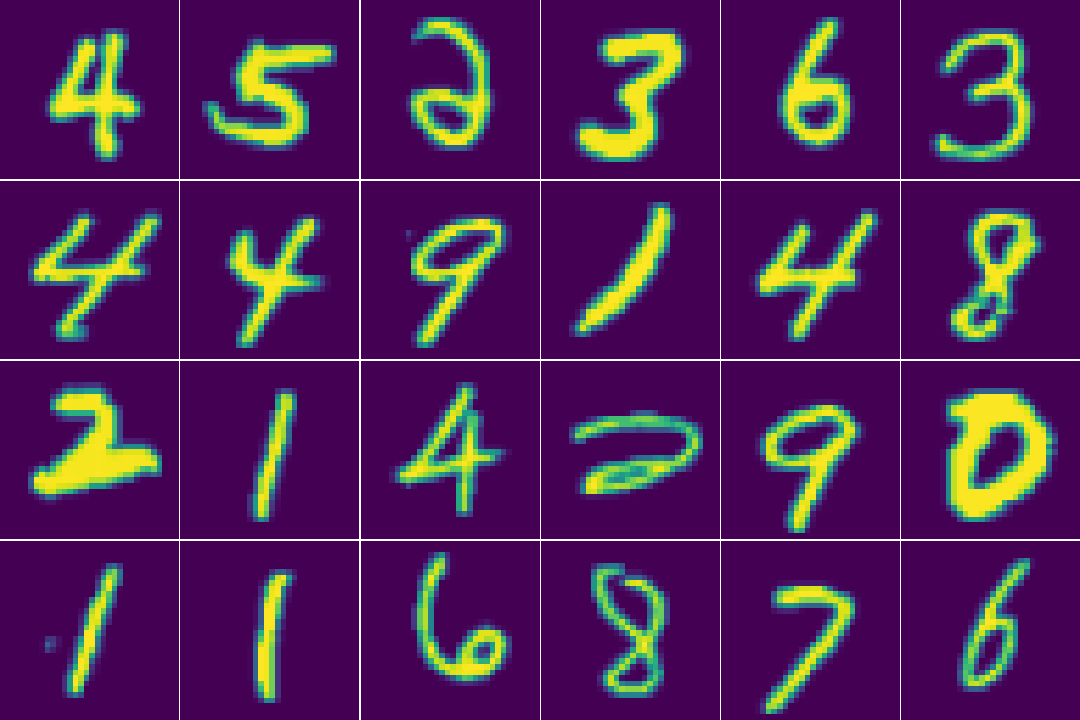

In [11]:
util.plot_imgs(X);

In [17]:
# with torch.no_grad():
#     logits = model(X)[0]
# util.plot_imgs(to_img(logits));

In [18]:
zs, ps = encode(X, t=0., prior=True)
rec = decode(zs)
util.plot_imgs(to_img(rec));

<IPython.core.display.Javascript object>


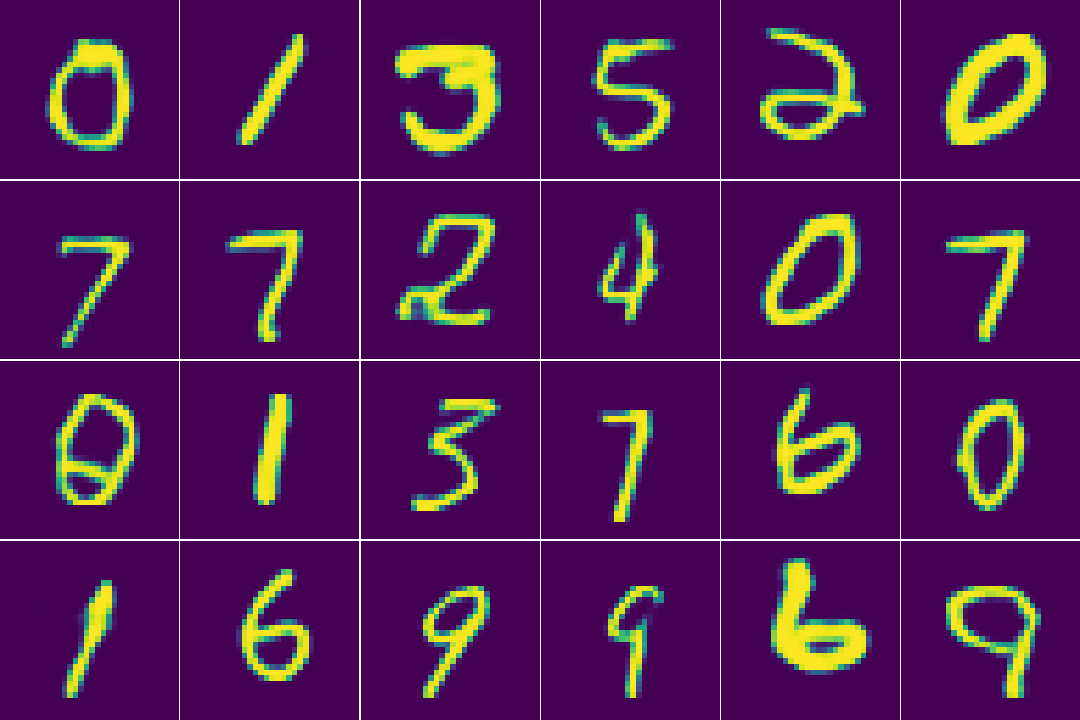

(<Figure size 720x480 with 24 Axes>, <numpy.flatiter at 0x1d982adfeb0>)

In [75]:
g = to_img(model.sample(24, t=1.))
util.plot_imgs(g)

<IPython.core.display.Javascript object>


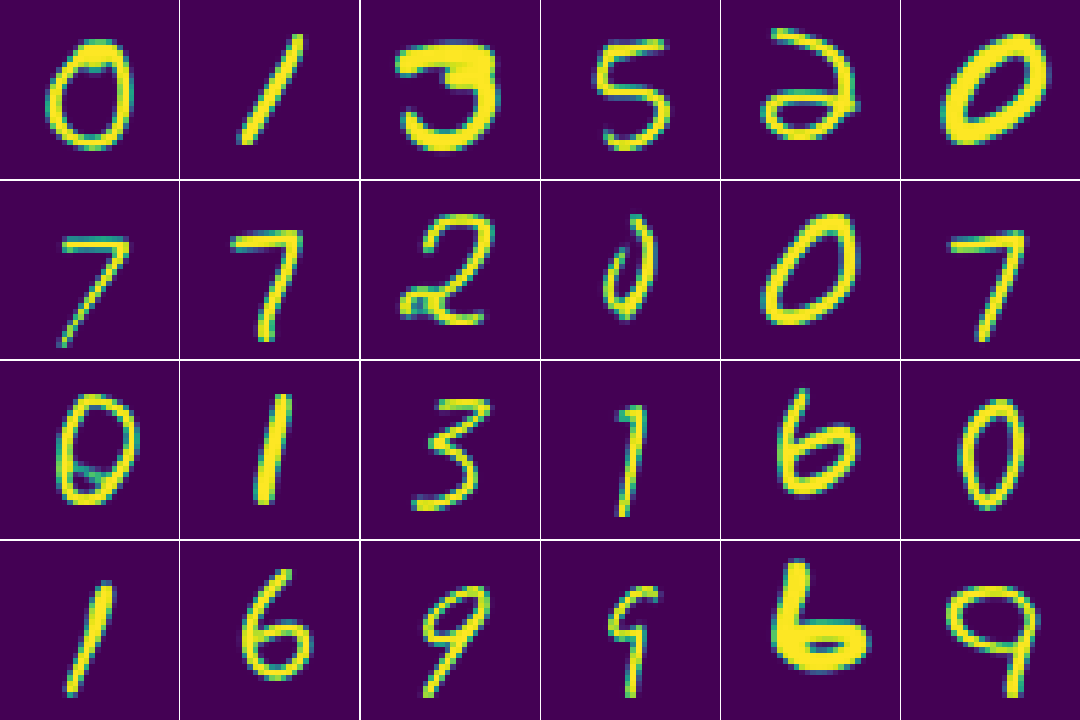

In [77]:
# idx = np.random.randint(len(X))

x = X.clone()
x = g.clone()
# x[:] = x[idx:idx+1]
Zs, Ps = encode(x, t=0., prior=True)
# util.plot_imgs(to_img(decode(encode(x,t=1))));
util.plot_imgs(to_img(decode(Zs)));

In [78]:
seqs = []
for num in range(1,len(Zs)):
    seqs.append(to_img(decode([*Zs[:num], Ps[num].sample()[0]],t=0.)))
seqs = torch.stack(seqs)
seqs.shape

torch.Size([14, 24, 1, 32, 32])

In [89]:
# bnum = 8
# sel = np.arange(len(x))[-5:]
# bnum = len(sel)
# util.plot_imgs(util.combine_dims(seqs[:, sel].contiguous(), start=0, end=2), W=bnum);

In [50]:
# num = 5
# zs = [*Zs[:num], Ps[num].sample()[0]]
# util.plot_imgs(to_img(decode(zs,t=0.)));

In [82]:
Ps[0].sample()[0].shape

torch.Size([24, 20, 4, 4])

In [88]:
# m = decode([Ps[0]], t=0)
# util.plot_imgs(to_img(decode([Ps[0]], t=0)));
# util.plot_imgs(to_img(decode([Ps[0]], t=0)));

In [90]:
q = Zs[0].sigma
q.shape

torch.Size([24, 20, 4, 4])

In [167]:
q = Ps[0].sample()[0]
q.shape

torch.Size([24, 20, 4, 4])

<IPython.core.display.Javascript object>


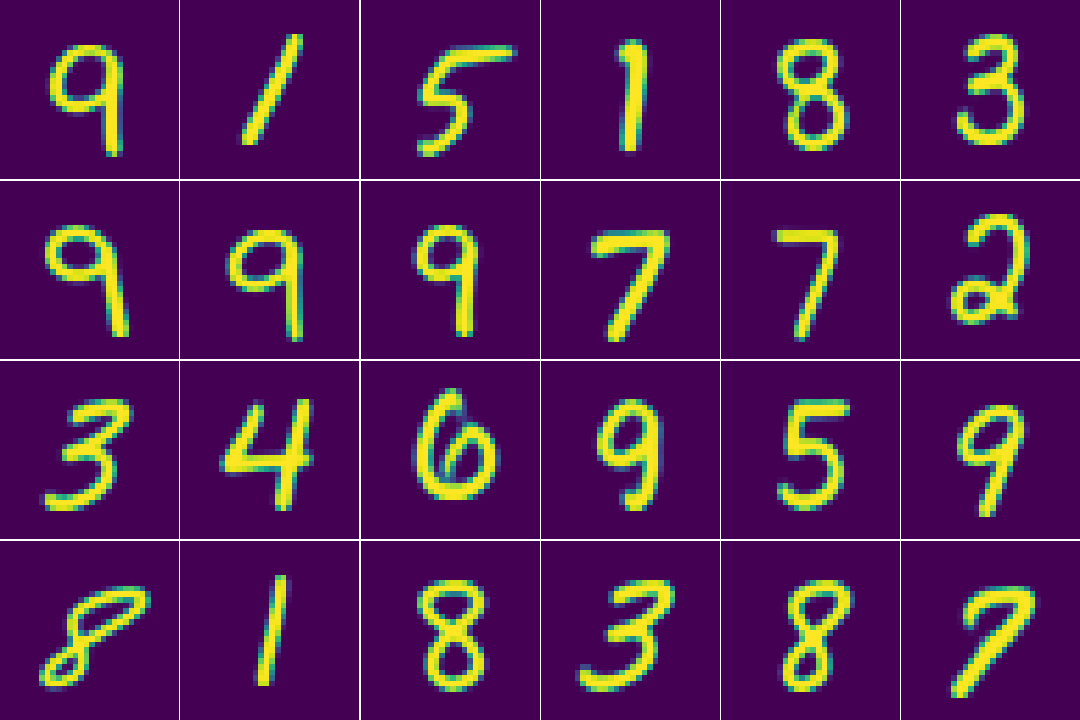

In [168]:
util.plot_imgs(to_img(decode([q], t=0)));

In [108]:
def enc(x):
    return encode(x, t=0)[0]
def dec(q):
    return to_img(decode([q], t=0))

In [105]:
o = enc(x)
o.mu.shape

torch.Size([24, 20, 4, 4])

In [107]:
q.shape

torch.Size([24, 20, 4, 4])

In [174]:
rdist = enc(dec(q))
sigma = rdist.sigma.mean(0)
sigma.shape

torch.Size([20, 4, 4])

In [194]:
dims = []
for ind in np.ndindex(sigma.shape):
    if (sigma < 0.8)[ind]:
        dims.append(ind)
dims

[(3, 2, 1), (3, 3, 1), (3, 3, 3)]

In [197]:
_dims = [(3, 2, 1), (3, 3, 1), (3, 3, 3)]
_dims = list(zip(*_dims))
_shape = [20,4,4]
def E(x):
    return enc(x).mu[(slice(None),*_dims)]
def D(q):
    z = torch.zeros(len(q), *_shape).to(q.device)
    z[(slice(None),*_dims)] = q
    return dec(z)
def prior(N):
    return torch.randn(N, len(_dims)).cuda()

In [201]:
# sigma[_dims]

<IPython.core.display.Javascript object>


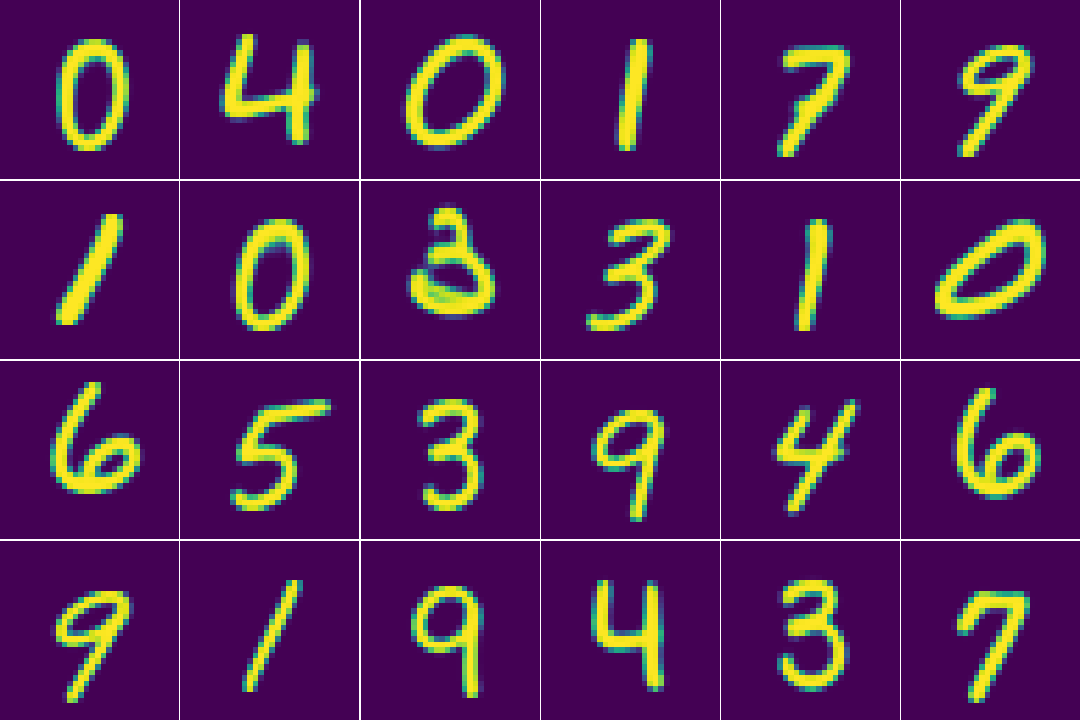

<IPython.core.display.Javascript object>


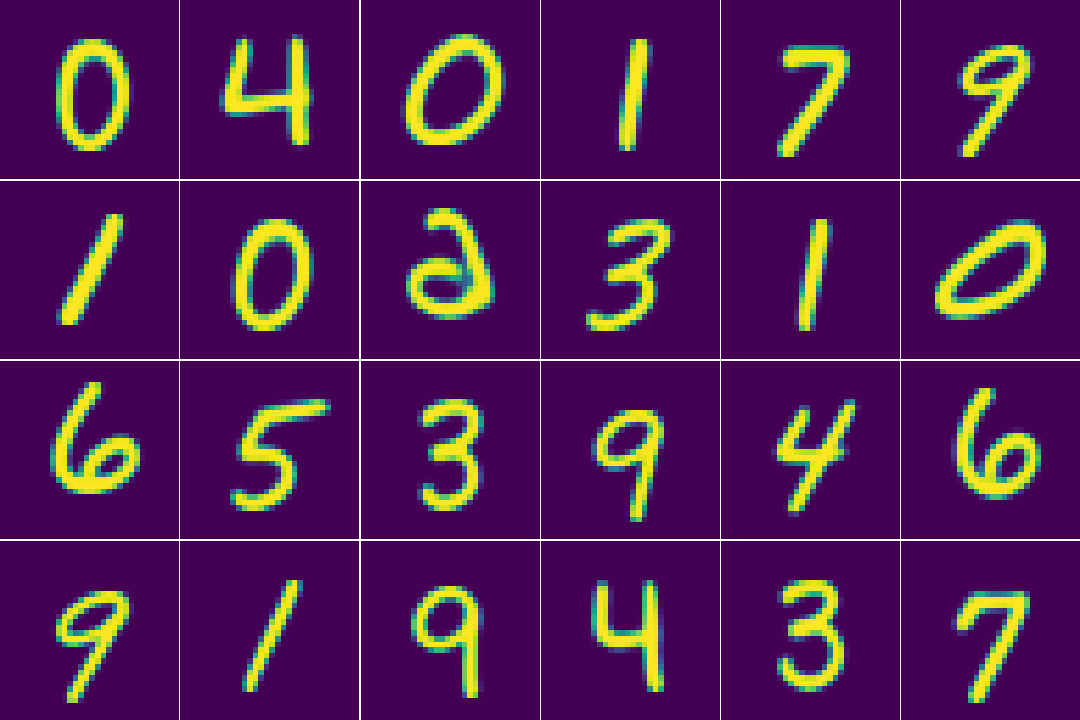

In [199]:
lat = prior(24)
util.plot_imgs(D(lat));
util.plot_imgs(D(E(D(lat))));

In [32]:
# util.plot_imgs(rec);

In [98]:
with torch.no_grad():
    lf, lcs = model.encode(X)

In [99]:
lf.shape

torch.Size([24, 256, 4, 4])

In [100]:
len(lcs), [lc.shape for lc in lcs]

(14,
 [torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 128, 8, 8]),
  torch.Size([24, 256, 4, 4]),
  torch.Size([24, 256, 4, 4]),
  torch.Size([24, 256, 4, 4]),
  torch.Size([24, 256, 4, 4])])

In [46]:
self = model

In [47]:
self.res_dist

True

In [50]:
from distributions import Normal, DiscMixLogistic, NormalDecoder

In [111]:
zs, ps = encode(X, t=1, prior=True)

In [92]:
zs = encode(X, t=1)
rec = decode(zs)
len(zs), rec.shape

(15, torch.Size([24, 1, 32, 32]))

In [86]:
[z.mu.shape for z in zs]

[torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8])]

In [89]:
sum(np.product(z.mu.shape[1:]) for z in zs), np.product(X.shape[1:])

(14400, 1024)

<IPython.core.display.Javascript object>


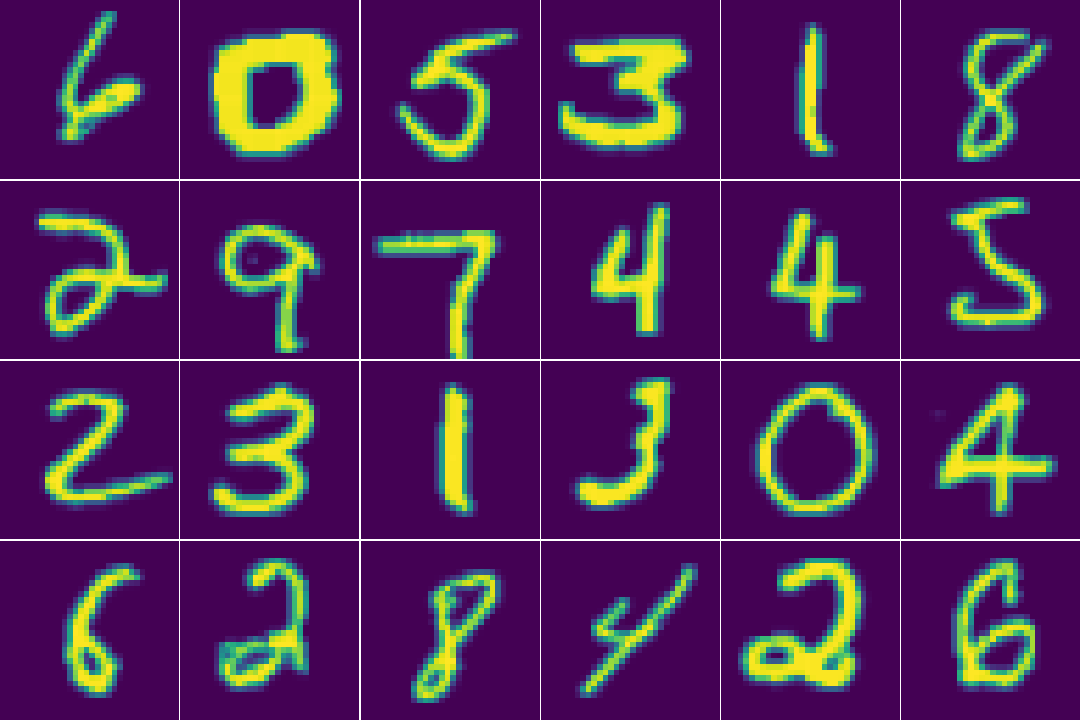

In [81]:
util.plot_imgs(X);

<IPython.core.display.Javascript object>


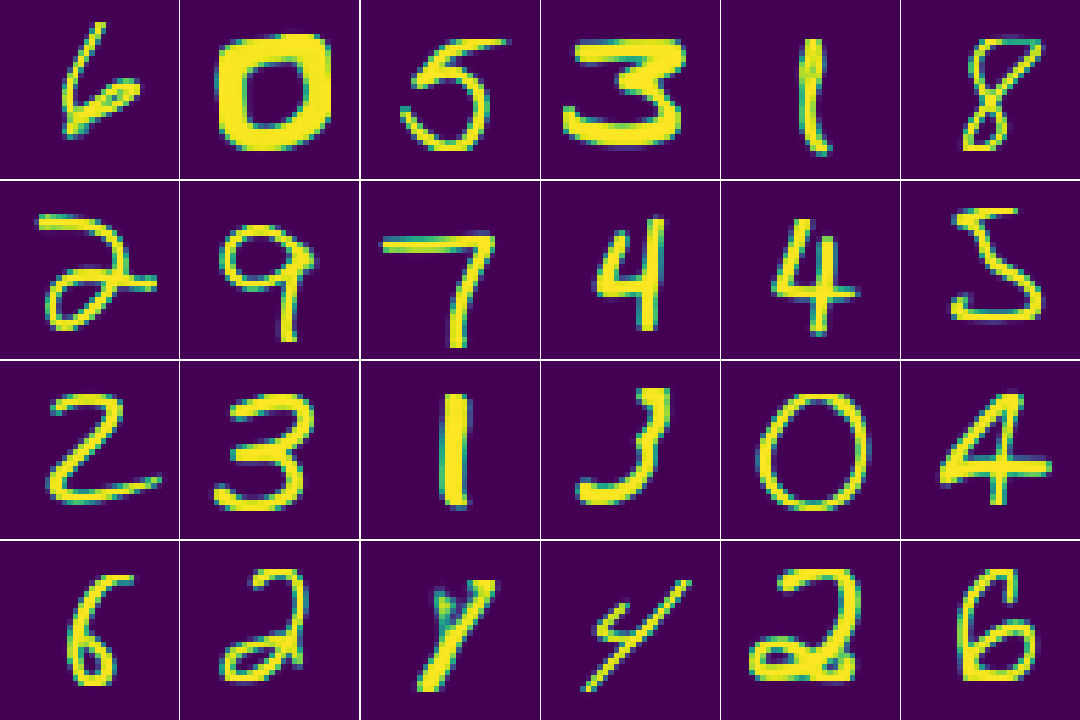

In [84]:
util.plot_imgs(to_img(rec));

<IPython.core.display.Javascript object>


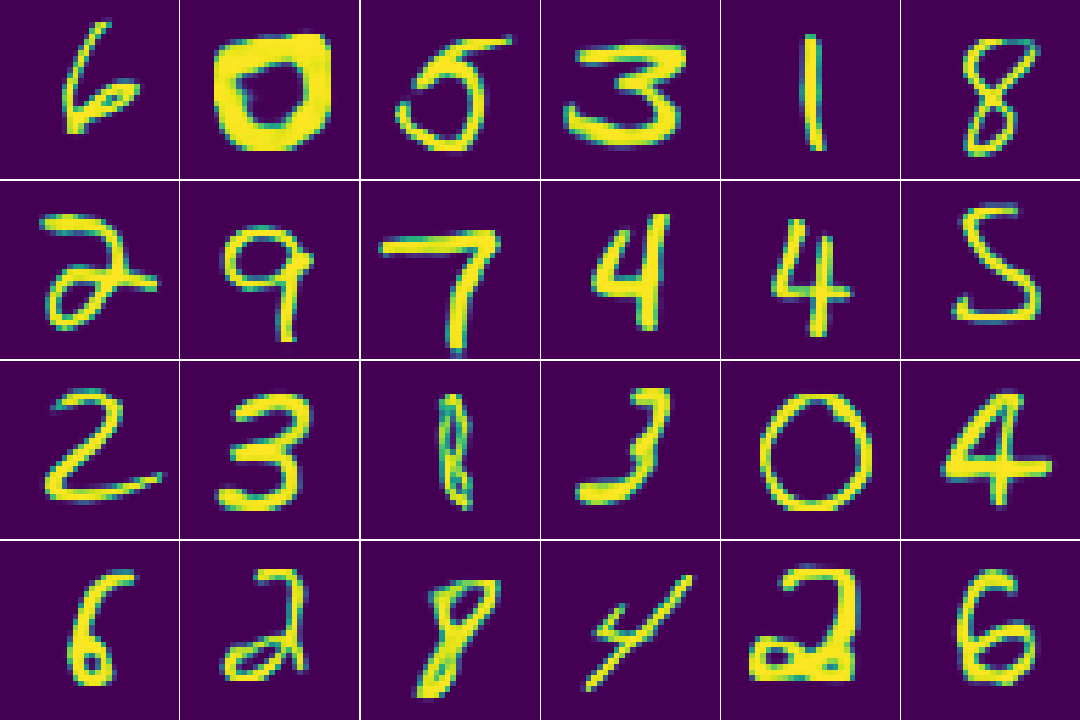

In [91]:
util.plot_imgs(to_img(rec));

<IPython.core.display.Javascript object>


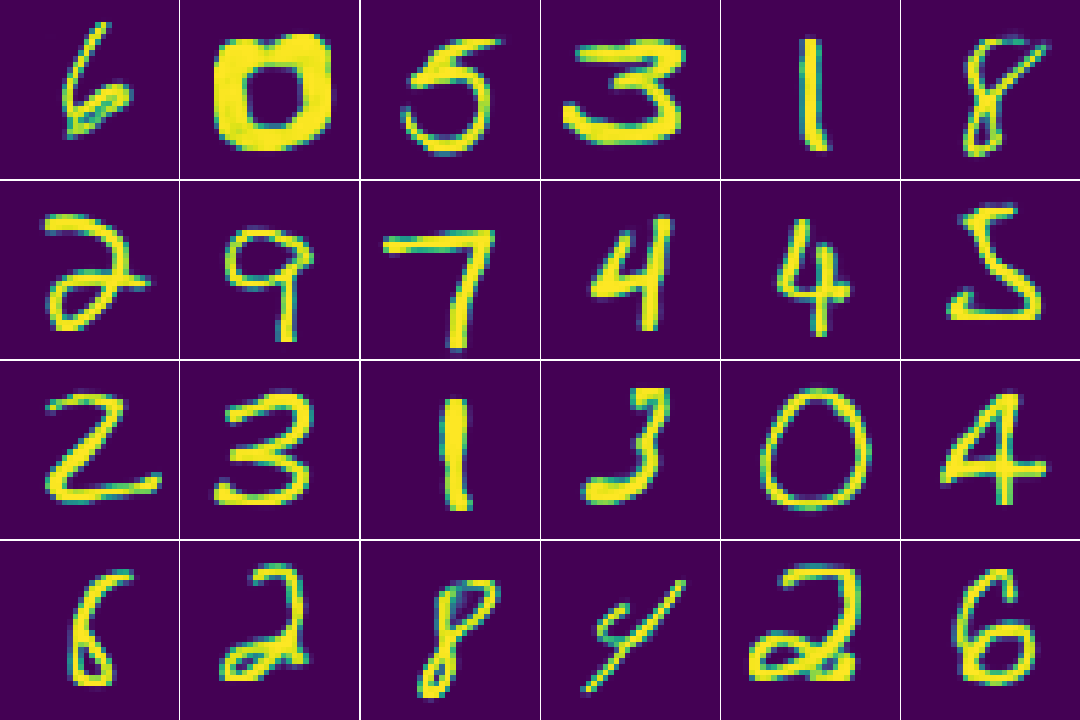

In [93]:
util.plot_imgs(to_img(rec));

In [53]:
len(all_q), len(all_q)

(15, 15)

In [55]:
[q.mu.shape for q in all_q]

[torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 4, 4]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8]),
 torch.Size([24, 20, 8, 8])]

<IPython.core.display.Javascript object>


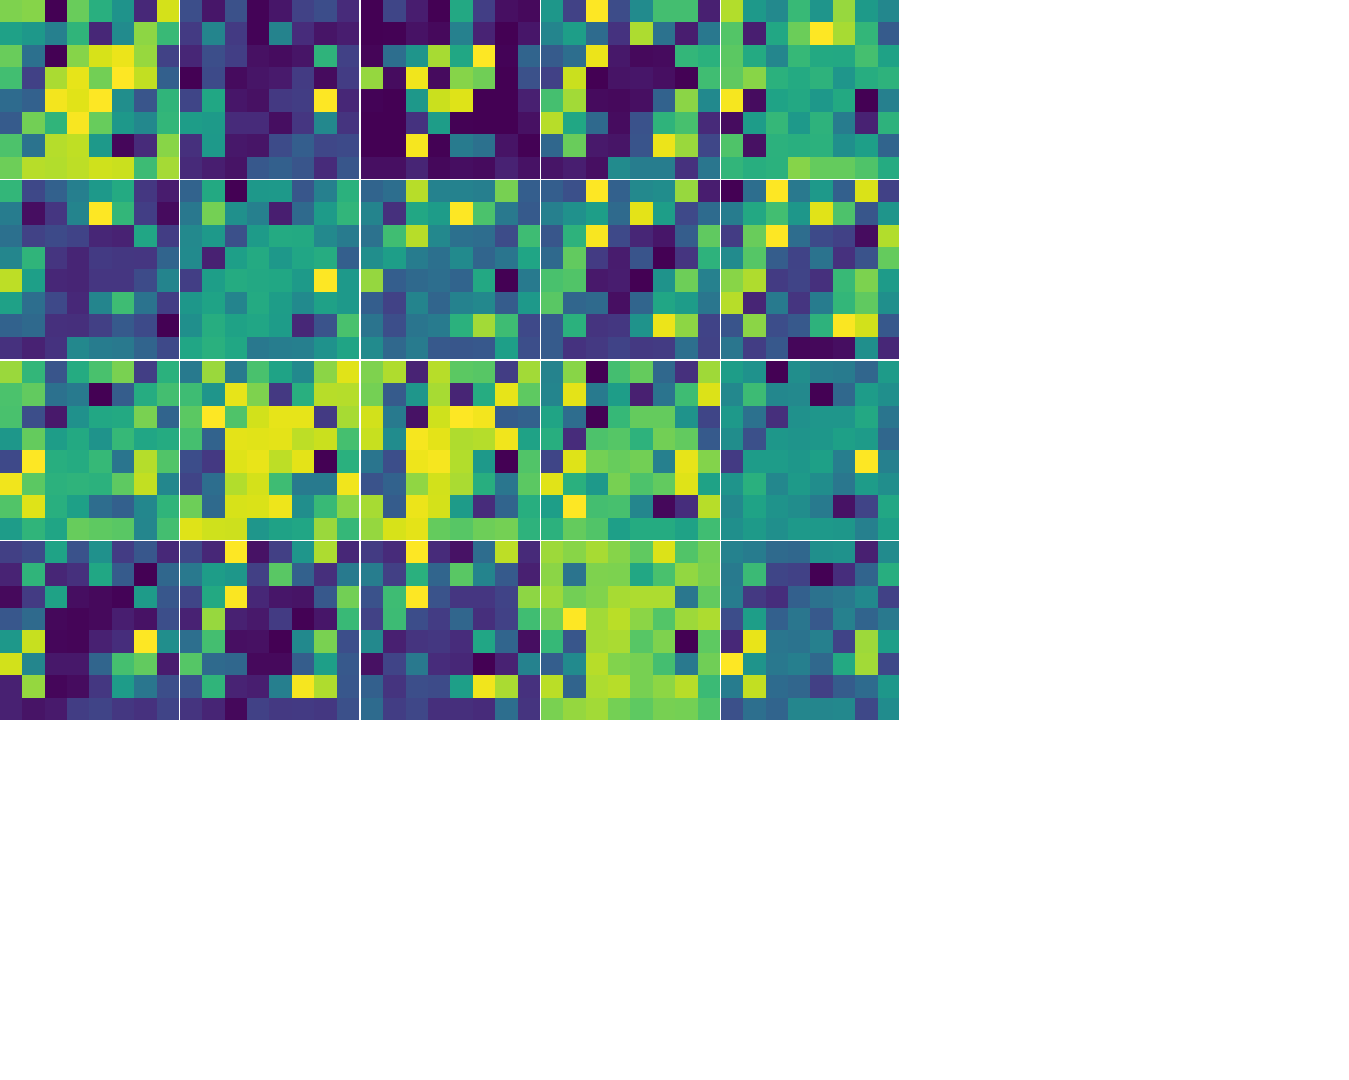

(<Figure size 600x480 with 20 Axes>, <numpy.flatiter at 0x1cab391c0f0>)

In [64]:
util.plot_imgs(all_q[-1].mu[0].unsqueeze(1))

In [55]:
def to_img(logits):
    with torch.no_grad():
        img = model.decoder_output(logits)
        img = img.mean if isinstance(img, torch.distributions.bernoulli.Bernoulli) \
                            else img.sample()
    return img

In [33]:
with torch.no_grad():
    rR = model.decode(lf, lcs)
    rR = model.decoder_output(rR)
    rR = rR.mean if isinstance(rR, torch.distributions.bernoulli.Bernoulli) \
                        else rR.sample()
util.plot_imgs(rR);

NameError: name 'lf' is not defined

In [ ]:
R = model.decoder_output(logits)
R_img = R.mean if isinstance(R, torch.distributions.bernoulli.Bernoulli) \
                    else R.sample()
util.plot_imgs(R_img);

In [35]:
self = model

In [36]:
len(self.dec_tower)

30

In [75]:
def decode(seed, t=1.):
    scale_ind = 0
    with torch.no_grad():
        z = seed#.clone()

        idx_dec = 0
        s = self.prior_ftr0.unsqueeze(0)
        batch_size = z.size(0)
        s = s.expand(batch_size, -1, -1, -1)
        for cell in self.dec_tower:
            if cell.cell_type == 'combiner_dec':
                if idx_dec > 0:
                    # form prior
                    param = self.dec_sampler[idx_dec - 1](s)
                    mu, log_sigma = torch.chunk(param, 2, dim=1)
                    dist = Normal(mu, log_sigma, t)
                    z, _ = dist.sample()

                # 'combiner_dec'
                s = cell(s, z)
                idx_dec += 1
            else:
                s = cell(s)
                if cell.cell_type == 'up_dec':
                    scale_ind += 1

        if self.vanilla_vae:
            s = self.stem_decoder(z)

        for cell in self.post_process:
            s = cell(s)

        logits = self.image_conditional(s)
    return logits

def encode(x):
    with torch.no_grad():
        s = self.stem(2 * x - 1.0)

        # perform pre-processing
        for cell in self.pre_process:
            s = cell(s)

        # run the main encoder tower
        combiner_cells_enc = []
        combiner_cells_s = []
        for cell in self.enc_tower:
            if cell.cell_type == 'combiner_enc':
                combiner_cells_enc.append(cell)
                combiner_cells_s.append(s)
            else:
                s = cell(s)

        # reverse combiner cells and their input for decoder
        combiner_cells_enc.reverse()
        combiner_cells_s.reverse()

        idx_dec = 0
        ftr = self.enc0(s)                            # this reduces the channel dimension
        param0 = self.enc_sampler[idx_dec](ftr)
        mu_q, log_sig_q = torch.chunk(param0, 2, dim=1)
    return mu_q, log_sig_q

In [82]:
num_samples, t = 24, 1.1

scale_ind = 0
z0_size = [num_samples] + self.z0_size
dist = Normal(mu=torch.zeros(z0_size).cuda(), log_sigma=torch.zeros(z0_size).cuda(), temp=t)
z0, _ = dist.sample()
# z0[:] = z0[:1]

In [83]:
z0.shape

torch.Size([24, 20, 4, 4])

<IPython.core.display.Javascript object>


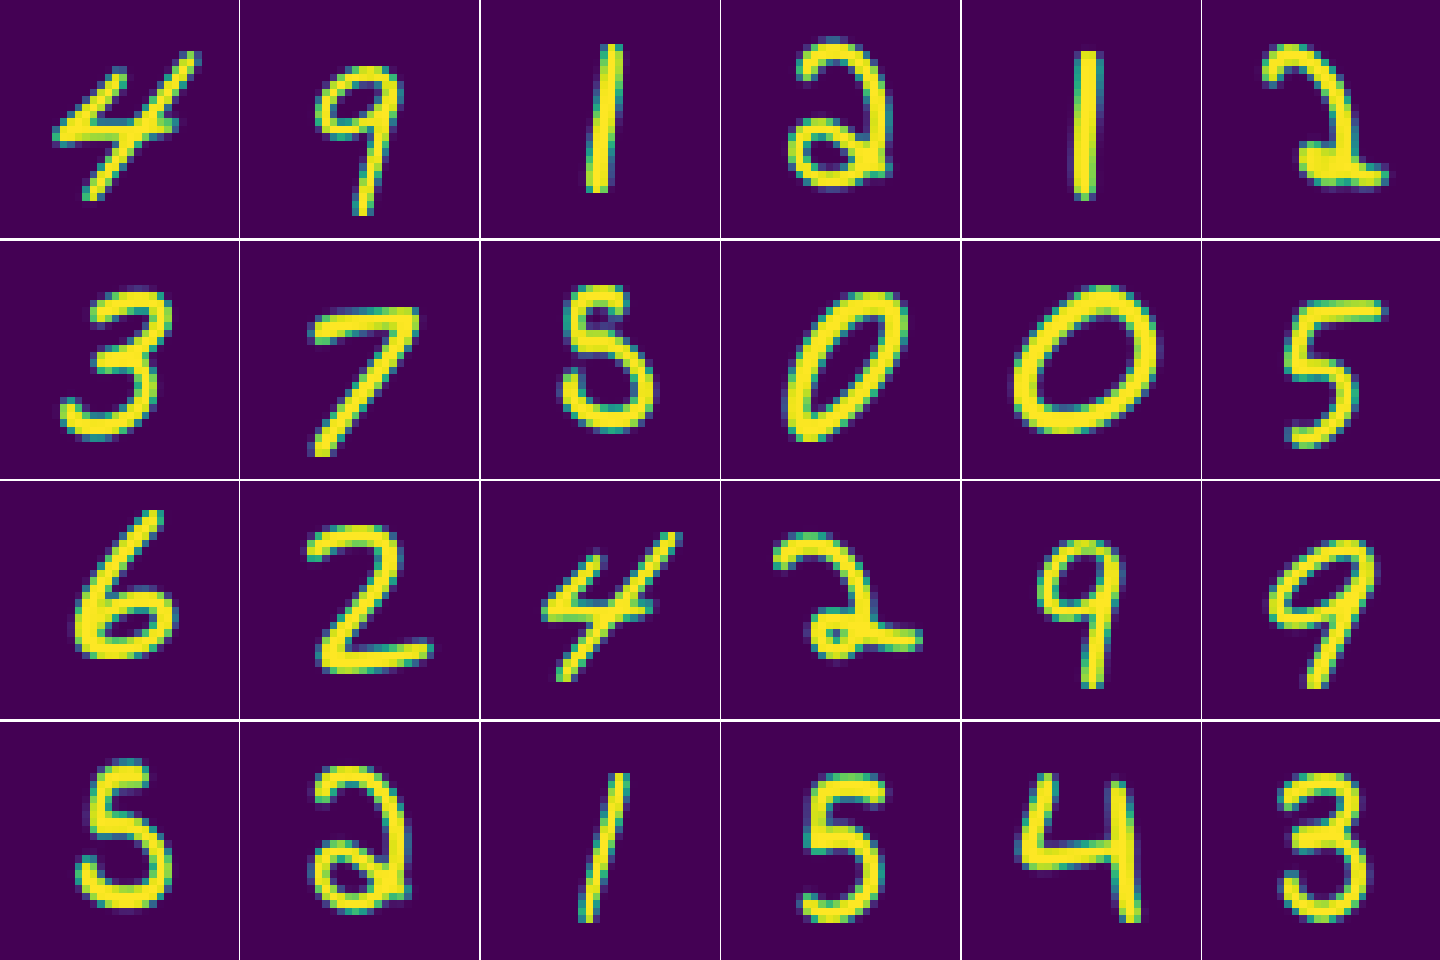

In [84]:
logits = decode(z0, t=0.)
imgs = to_img(logits)
util.plot_imgs(imgs);

<IPython.core.display.Javascript object>


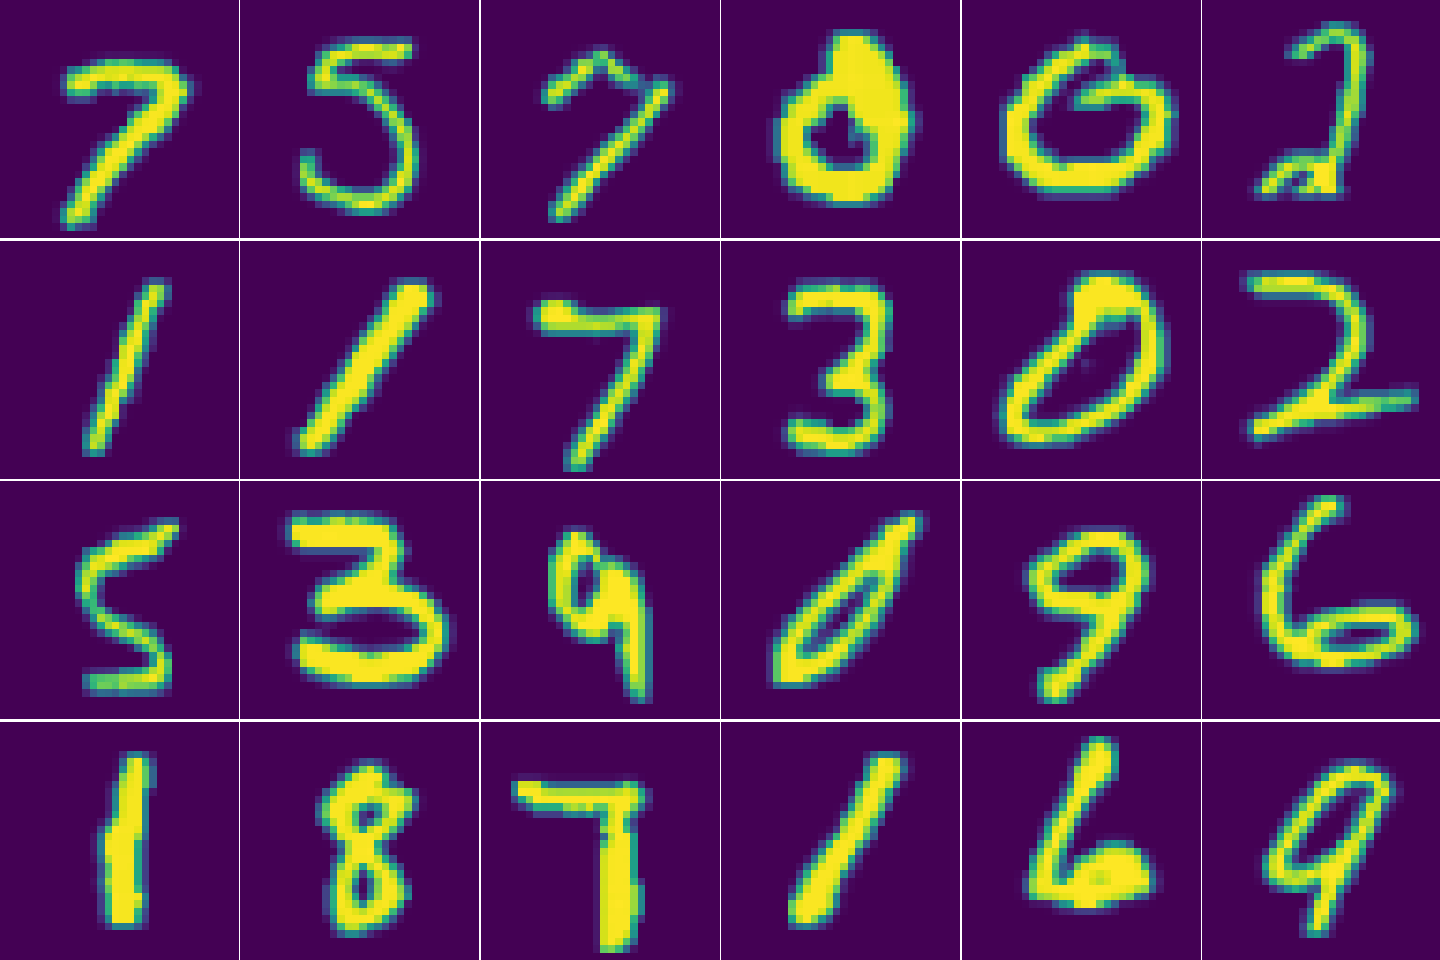

In [89]:
util.plot_imgs(X);

In [90]:
lat, _ = encode(X)
lat.shape

torch.Size([24, 20, 4, 4])

<IPython.core.display.Javascript object>


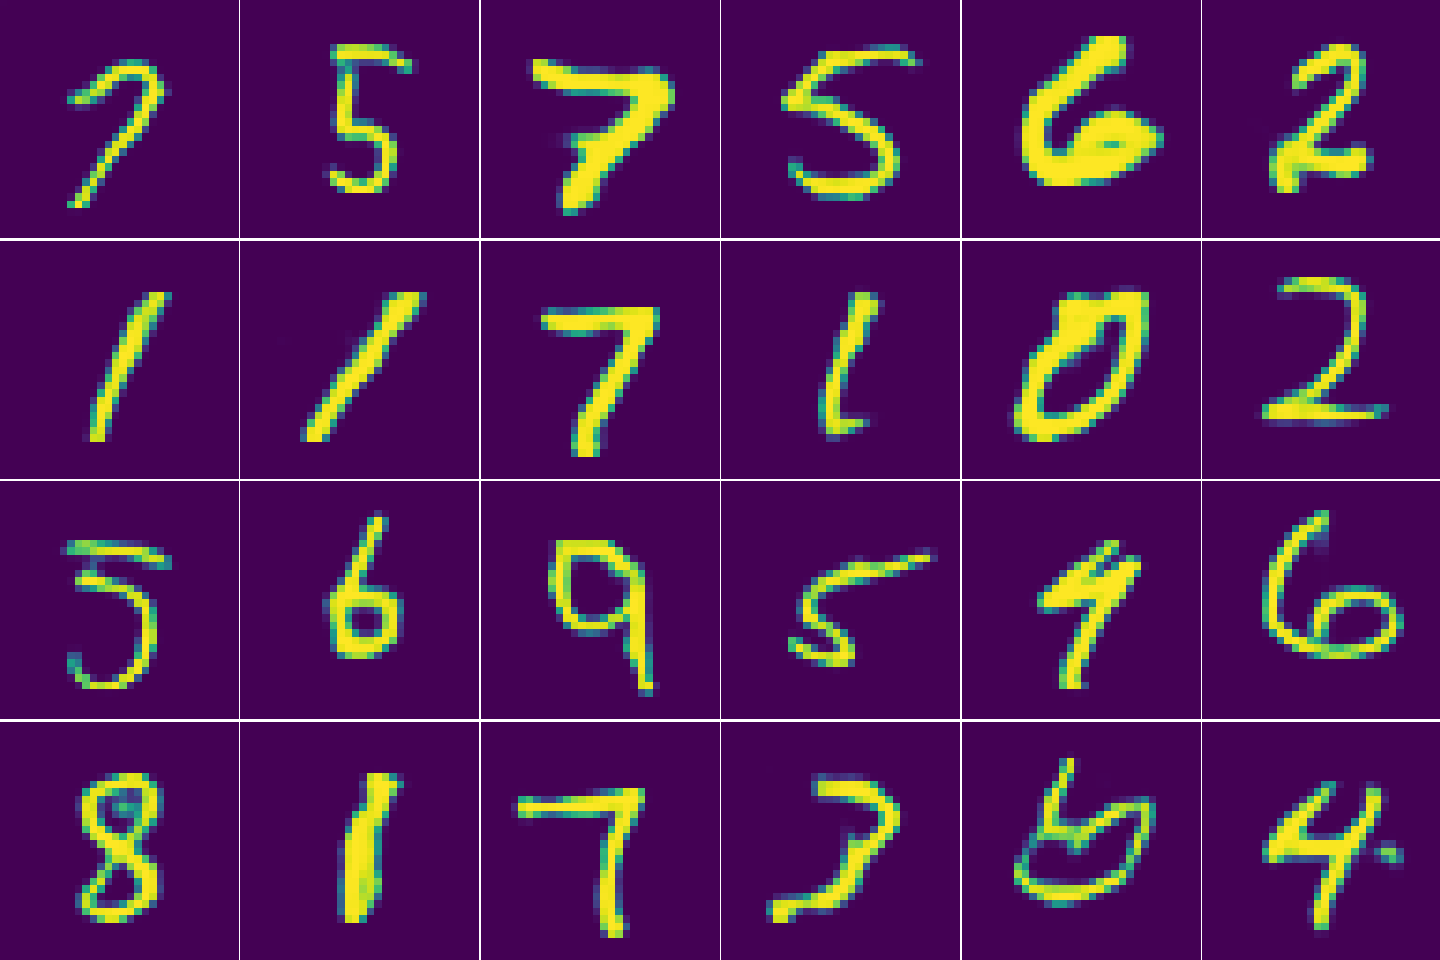

In [95]:
rlts = decode(lat, t=1.1)
recs = to_img(rlts)
util.plot_imgs(recs);

In [47]:
x = X.clone()
x.shape

torch.Size([24, 1, 32, 32])

In [68]:

with torch.no_grad():
    s = self.stem(2 * x - 1.0)

    # perform pre-processing
    for cell in self.pre_process:
        s = cell(s)

    # run the main encoder tower
    combiner_cells_enc = []
    combiner_cells_s = []
    for cell in self.enc_tower:
        if cell.cell_type == 'combiner_enc':
            combiner_cells_enc.append(cell)
            combiner_cells_s.append(s)
        else:
            s = cell(s)

    # reverse combiner cells and their input for decoder
    combiner_cells_enc.reverse()
    combiner_cells_s.reverse()

    idx_dec = 0
    ftr = self.enc0(s)                            # this reduces the channel dimension
    param0 = self.enc_sampler[idx_dec](ftr)
    mu_q, log_sig_q = torch.chunk(param0, 2, dim=1)

In [69]:
mu_q.shape

torch.Size([24, 20, 4, 4])

In [70]:
lat = mu_q #Normal(mu=mu_q, log_sigma=torch.zeros(z0_size).cuda(), temp=t).sample()
lat.shape

torch.Size([24, 20, 4, 4])

In [ ]:
util.plot_imgs(to_img(logits));
logits.shape

In [16]:
dataset = fig.quick_run('load-data', name='celeba', size=64, **{'_dataset_mod': 'interpolated'})
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: True (by default)
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'celeba'
|  > _dataset_mod: 'interpolated'
|  > default_mode --> mode: 'train' (by default)
|  > mode-aliases: {} (by default)
|  > seed: 3559967690 (by default)
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 3903927794 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/celeba) (mod=interpolated)
|  >  > interpolate-size --> size: 64
|  >  > interpolate-mode: 'bilinear' (by default)
|  >  > crop_size: 128 (by default)
|  >  > c

162770

In [17]:
dataset.get_dims()

((3, 64, 64), (3, 64, 64))

In [18]:
X, *other = dataset.get_batch(batch_size=16)
X.shape, len(other)

C:\Users\anwan\Anaconda3\lib\site-packages\torch\nn\functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(torch.Size([16, 3, 64, 64]), 0)

<IPython.core.display.Javascript object>


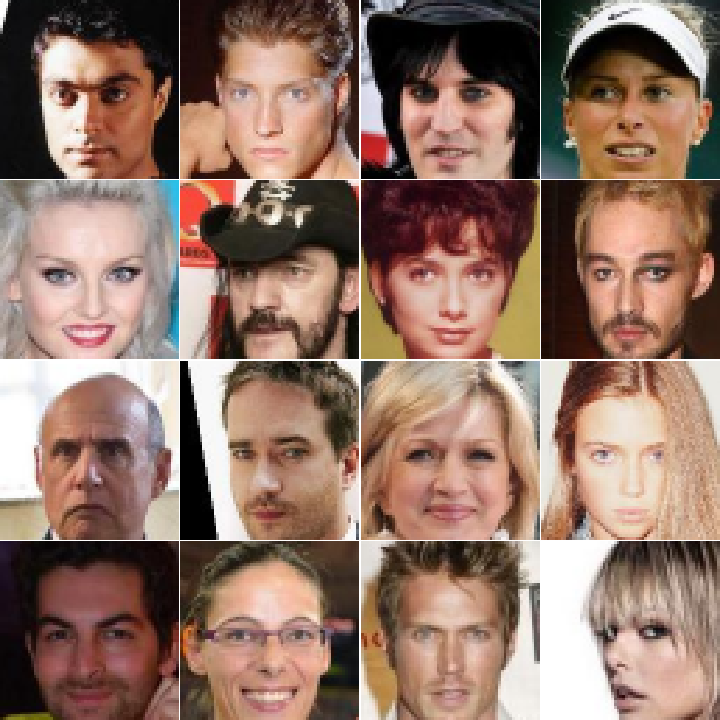

(<Figure size 480x480 with 16 Axes>, <numpy.flatiter at 0x24b9e72d290>)

In [19]:
util.plot_imgs(X)

In [20]:
with torch.no_grad():
    logits, log_q, log_p, kl_all, kl_diag = model(X)
    output = model.decoder_output(logits)
    rec = output.sample()
logits.shape, rec.shape

(torch.Size([16, 100, 64, 64]), torch.Size([16, 3, 64, 64]))

<IPython.core.display.Javascript object>


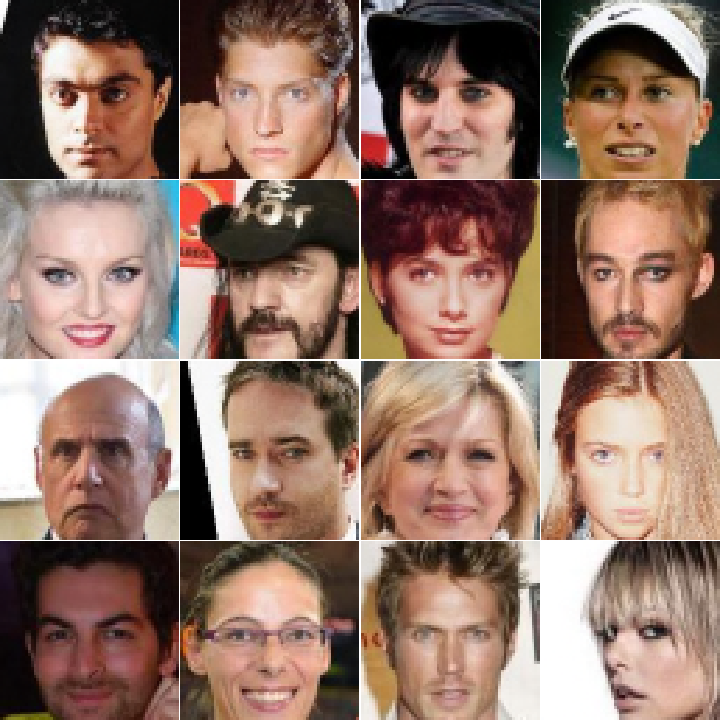

In [22]:
util.plot_imgs(rec);

In [23]:
output.logit_probs.shape

torch.Size([16, 10, 64, 64])

In [24]:
loss = F.mse_loss(X, rec, reduction='none')
loss.shape

torch.Size([16, 3, 64, 64])

In [25]:
loss.max()

tensor(0.0133, device='cuda:0')

In [26]:
model.image_conditional

Sequential(
  (0): ELU(alpha=1.0)
  (1): Conv2D(64, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [27]:
len(model.dec_tower)

105

In [28]:
len(model.enc_tower)

106

In [29]:
len(model.dec_sampler)

34

In [30]:
model.dec_sampler

ModuleList(
  (0): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(512, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(512, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(512, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(512, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (4): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(256, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (5): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(256, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (6): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(256, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (7): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(256, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (8): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(256, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (9): Sequential(
    (0

In [31]:
model.res_dist

True

In [32]:
len(model.dec_tower)

105

In [33]:
cells = [cell for cell in model.dec_tower if cell.cell_type == 'combiner_dec']
len(cells)

35

In [34]:
vals = torch.stack([cell.conv.weight.squeeze()[:,-20:].abs().sum(0) for cell in cells])
vals.shape

torch.Size([35, 20])

<IPython.core.display.Javascript object>


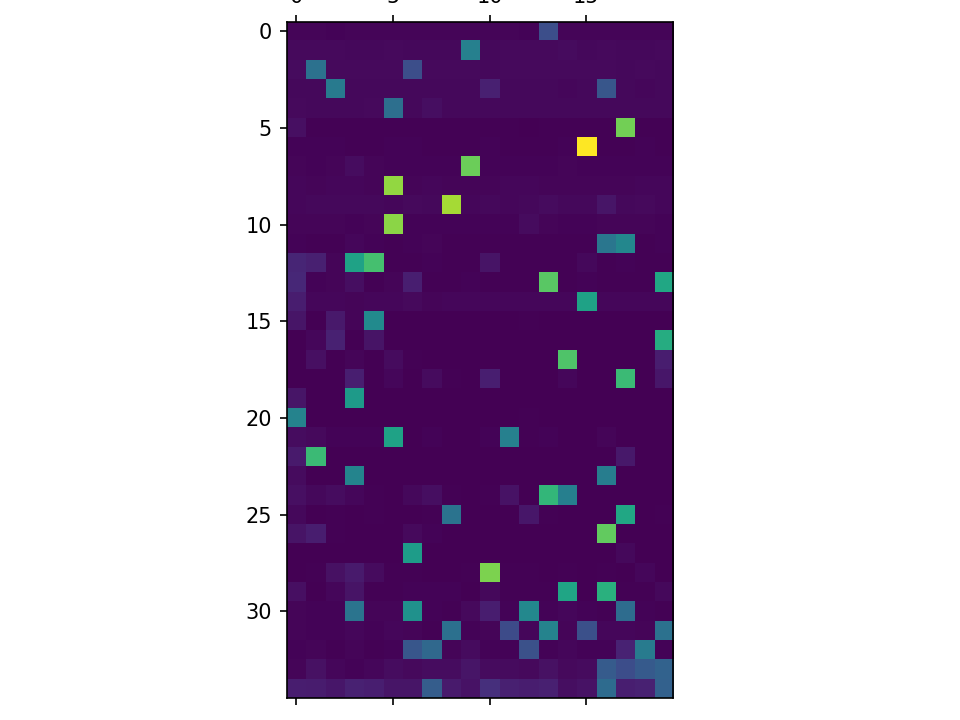

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24a59b42a48>)

In [35]:
util.plot_mat(vals)

In [36]:
vals.gt(1).sum(), vals.numel()

(tensor(439, device='cuda:0'), 700)

<IPython.core.display.Javascript object>


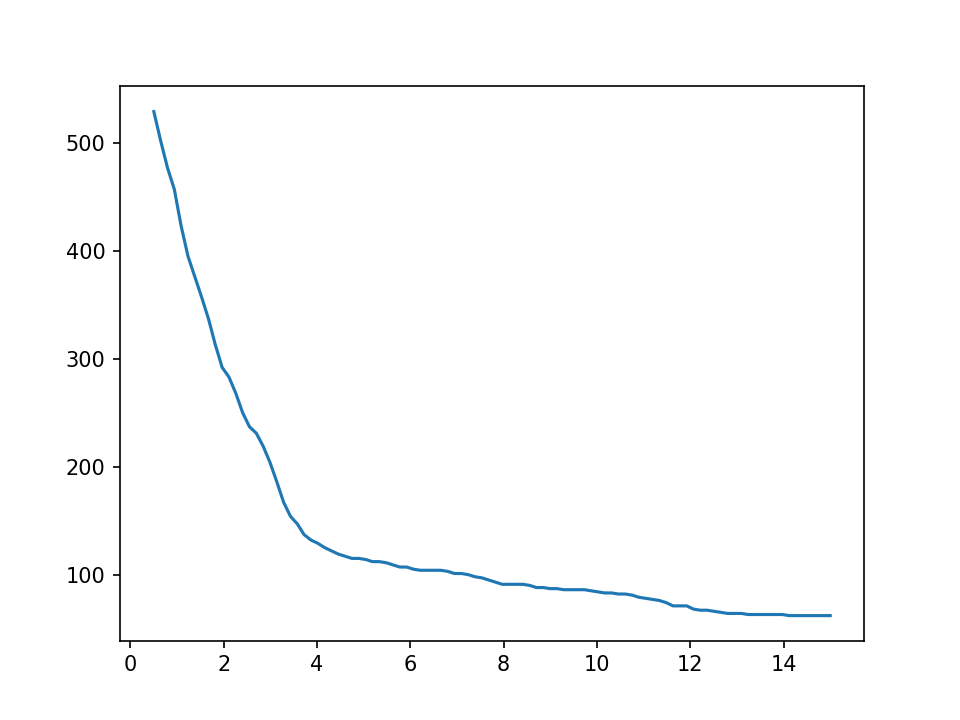

In [37]:
plt.figure()
x = torch.linspace(0.5,15, 100, device=vals.device)
plt.plot(x.cpu(), vals.view(1, -1).gt(x.unsqueeze(-1)).sum(-1).cpu());